In [121]:
from BezierCasadi import *
from TimeOptBez import *
import numpy as np

In [122]:
import casadi as ca
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile
import os
import datetime


class Bezier:
#https://en.wikipedia.org/wiki/B%C3%A9zier_curve

    def __init__(self, P: ca.SX, T: float):
        self.P = P
        self.m = P.shape[0]
        self.n = P.shape[1]-1
        self.T = T
    
    def eval(self, t):
        #https://en.wikipedia.org/wiki/De_Casteljau%27s_algorithm
        beta = t/self.T
        A = ca.SX(self.P)
        for j in range(1, self.n + 1):
            for k in range(self.n + 1 - j):
                A[:, k] = A[:, k] * (1 - beta) + A[:, k + 1] * beta
        return A[:, 0]
    
    def deriv(self, m=1):
        D = ca.SX(self.P)
        for j in range(0, m):
            D = (self.n - j)*ca.horzcat(*[ D[:, i+1] - D[:, i] for i in range(self.n - j) ])
        return Bezier(D/self.T**m, self.T)

In [123]:
def derive_bezier6():
    n = 6
    T = ca.SX.sym('T')
    t = ca.SX.sym('t')
    P = ca.SX.sym('P', 1, n)
    B = Bezier(P, T)

    # derivatives
    B_d = B.deriv()
    B_d2 = B_d.deriv()
    B_d3 = B_d2.deriv()
    B_d4 = B_d3.deriv()

    # boundary conditions

    # trajectory
    p = B.eval(t)
    v = B_d.eval(t)
    a = B_d2.eval(t)
    j = B_d3.eval(t)
    s = B_d4.eval(t)
    r = ca.vertcat(p, v, a, j, s)

    # given position/velocity boundary conditions, solve for bezier points
    wp_0 = ca.SX.sym('p0', 2, 1)  # pos/vel at waypoint 0
    wp_1 = ca.SX.sym('p1', 2, 1)  # pos/vel at waypoint 1

    constraints = []
    constraints += [(B.eval(0), wp_0[0])]  # pos @ wp0
    constraints += [(B_d.eval(0), wp_0[1])]  # vel @ wp0
    constraints += [(B_d2.eval(0), 0)]  # zero accel @ wp0
    constraints += [(B.eval(T), wp_1[0])]  # pos @ wp1
    constraints += [(B_d.eval(T), wp_1[1])]  # vel @ wp1
    constraints += [(B_d2.eval(T), 0)]  # zero accel @ wp1

    assert len(constraints) == 6

    Y = ca.vertcat(*[c[0] for c in constraints])
    b = ca.vertcat(*[c[1] for c in constraints])
    A = ca.jacobian(Y, P)
    A_inv = ca.inv(A)
    P_sol = (A_inv@b).T
    return {
        'bezier6_solve': ca.Function('bezier6_solve', [wp_0, wp_1, T], [P_sol], ['wp_0', 'wp_1', 'T'], ['P']),
        'bezier6_traj': ca.Function('bezier6_traj', [t, T, P], [r], ['t', 'T', 'P'], ['r']),
    }

In [124]:
def multiRotor_timeOpt(bc,k_time): ## Currently outputs optimized time
    time_opt = find_opt_time(6, bc,k_time)
    return np.average(time_opt)

In [125]:
def multiRotor_plan(bc,T0):
    T0 = 2.3151252777563114  ##Use optimized time from "dev-Bezier_FindOptimizeFunc.ipynb"
    bezier_6 = derive_bezier6()

    bc = np.array(bc)
    t0 = np.linspace(0, T0, 1000)

    PX = bezier_6['bezier6_solve'](bc[:, 0, 0], bc[:, 1, 0], T0)
    traj_x = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PX)).T

    PY = bezier_6['bezier6_solve'](bc[:, 0, 1], bc[:, 1, 1], T0)
    traj_y = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PY)).T

    PZ = bezier_6['bezier6_solve'](bc[:, 0, 2], bc[:, 1, 2], T0)
    traj_z = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PZ)).T

    x = traj_x[:, 0]
    vx = traj_x[:, 1]
    ax = traj_x[:, 2]

    y = traj_y[:, 0]
    vy = traj_y[:, 1]
    ay = traj_y[:, 2]

    z = traj_z[:, 0]
    vz = traj_z[:, 1]
    az = traj_z[:, 2]

    V = np.sqrt(vx**2 + vy**2 + vz**2)


    return x,vx,ax,y,vy,ay,z,vz,az

bc = np.array([
    [ # position
        [1, 2, 3],  # wp0, x, y, z
        [2, 3, 4]   # wp1, x, y, z
    ],
    [ # velocity
        [1, 0, 1],
        [0, 1, -1]
    ]
])


In [126]:
bc_t = np.array([
    [ # position
        [1, 2, 1],  # wp0, x, y, z
        [2, 3, 4],   # wp1, x, y, z
        [-2, 1, 3],   # wp2, x, y, z
        [2, -1, 3]
    ],
    [ # velocity
        [1, 0, 1],
        [0, 1, 0],
        [0, 1, -1],
        [1, 0, 0]

    ]
])


In [127]:
k =10
# t0 = np.linspace(0, T0, 3000)
t_total = 0
x1 = np.array([])
vx1 = np.array([])
ax1 = np.array([])
y1 = np.array([])
vy1 = np.array([])
ay1 = np.array([])
z1 = np.array([])
vz1 = np.array([])
az1 = np.array([])

for i in range(bc_t.shape[1]-1):
    bc = bc_t[:,i:i+2,:]
    T0 = multiRotor_timeOpt(bc,k)
    t_total = t_total + T0 
    x,vx,ax,y,vy,ay,z,vz,az= multiRotor_plan(bc,T0)
    x1 = np.append(x1,x)
    vx1 = np.append(vx1,vx)
    ax1 = np.append(ax1,ax)
    y1 = np.append(y1,y)
    vy1 = np.append(vy1,vy)
    ay1 = np.append(ay1,ay)
    z1 = np.append(z1,z)
    vz1 = np.append(vz1,vz)
    az1 = np.append(az1,az)
    display(T0)
t_array = np.linspace(0,t_total,x1.size)

2.75160519711989

4.1167269409605085

3.8045425378946858

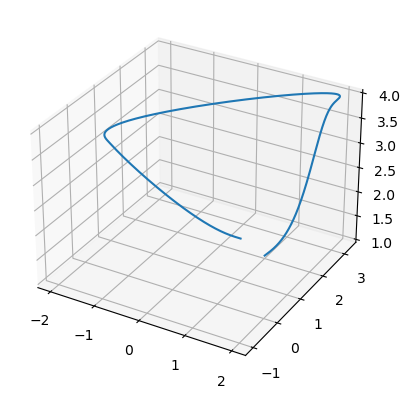

In [128]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x1,y1,z1)

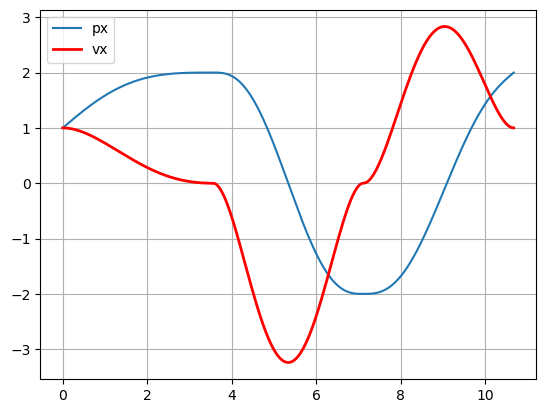

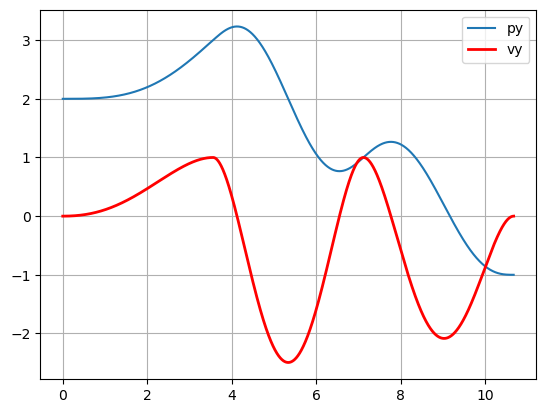

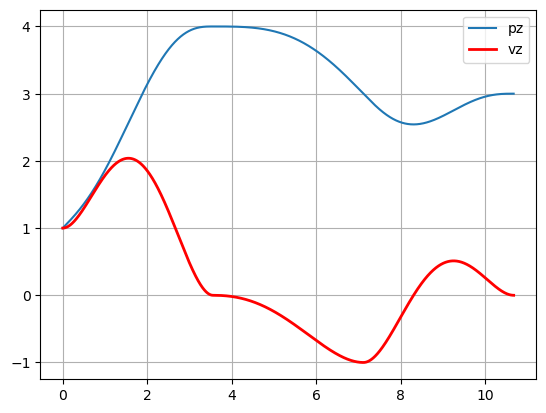

In [129]:
plt.figure()
plt.plot(t_array, x1, label='px')
plt.plot(t_array, vx1, label='vx', linewidth=2, color='red')
# plt.plot(t_array, ax1, label='ax', color='orange', linewidth=3)  
plt.legend()
plt.grid()

plt.figure()
plt.plot(t_array, y1, label='py')
plt.plot(t_array, vy1, label='vy', linewidth=2, color='red')
# plt.plot(t_array, ay1, label='ay', color='orange', linewidth=3)  
plt.legend()
plt.grid() 

plt.figure()
plt.plot(t_array, z1, label='pz')
plt.plot(t_array, vz1, label='vz', linewidth=2, color='red')
# plt.plot(t_array, az1, label='az', color='orange', linewidth=3)  
plt.legend()
plt.grid() 

SOLVING FOR MULTIROTOR Dynamics:

In [130]:
tol = 1e-4
g = 9.81
m = 1 # mass

def solve_multiRotor_dynamics(traj_x,traj_y,traj_z):
    #unit vector in body frame
    xh = ca.transpose(ca.SX([1, 0, 0]))
    yh = ca.transpose(ca.SX([0, 1, 0]))
    zh = ca.transpose(ca.SX([0, 0, 1]))

    #position, velocity, acceleration for derived curve
    px = traj_x[0]
    vx = traj_x[1]
    ax = traj_x[2]
    jx = traj_x[3]
    sx = traj_x[4]

    py = traj_y[0]
    vy = traj_y[1]
    ay = traj_y[2]
    jy = traj_y[3]
    sy = traj_y[4]

    pz = traj_z[0]
    vz = traj_z[1]
    az = traj_z[2]
    jz = traj_z[3]
    sz = traj_z[4]

    #flat output expressed in e frame
    p_e = ca.hcat([px, py, pz])
    v_e = ca.hcat([vx, vy, vz])
    a_e = ca.hcat([ax, ay, az])
    j_e = ca.hcat([jx, jy, jz])
    s_e = ca.hcat([sx, sy, sz])

    #Newton second law
    thrust_e = m * (g* zh - a_e)

    #check for singularity
    thrust = ca.if_else(thrust_e >tol, ca.norm_2(thrust_e), tol) #normalize thrust term
    zb_e = thrust_e / thrust

    #desired heading angle (desired yaw angle)
    psi_des = 0 #keep psi angle 0 wrt to camera frame #Recheck

    #desired heading direction
    xc_e = ca.cos(psi_des) * xh + ca.sin(psi_des) * yh

    yb_e = ca.cross(zb_e,xc_e)
    N_yb_e = ca.norm_2(yb_e)
    yb_e = ca.if_else(
        N_yb_e > tol, yb_e / N_yb_e, yh
    )  # normalize y_b, can have singularity when z_b and x_c aligned
    
    xb_e = ca.cross(yb_e, zb_e)  
    
    C_be =  ca.hcat([xb_e, yb_e, zb_e]) #C_be

    return C_be
    

In [132]:
solve_multiRotor_dynamics(x1,y1,z1) 
#with camera position along the multirotor (desired angle 0)

SX([[20000, -10046.3, 0.486837, 0, 4.84591e-05, 1, -10046.3, -20000, 0.969182]])